List of Ideas:
- See bookmarks:
- Automating Feature Engineering (Part II)
- Use LightGBM for feature importance (Crypto Forecasting - lgbm feval+feature importance)
- Crypto Forecasting - Common Factors
- Correlation as loss function ? https://www.kaggle.com/competitions/open-problems-multimodal/discussion/347595#1916337
-

In [19]:
import tensorflow as tf
tf.random.set_seed(42)
import tensorflow.python.keras.backend as K
import tensorflow.python.keras.layers as layers
from tensorflow.python.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls=1e-2, lr=1e-3):
    inp = tf.keras.layers.Input(shape=(num_columns,))
    x0 = tf.keras.layers.BatchNormalization()(inp)

    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)

    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name='decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='ae_action')(x_ae)

    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)

    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)

    out = tf.keras.layers.Dense(num_labels, activation='softmax', name='action')(x)

    model = tf.keras.models.Model(inputs=inp, outputs=[decoder, out_ae, out])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss={'decoder': tf.keras.losses.MeanSquaredError(),
                        'ae_action': tf.keras.losses.CategoricalCrossentropy(),
                        'action': tf.keras.losses.CategoricalCrossentropy(),
                        },
                  metrics={'decoder': tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                           'ae_action': tf.keras.metrics.AUC(name='AUC'),
                           'action': tf.keras.metrics.AUC(name='AUC'),
                           },
                  )

    return model

In [20]:
import tensorflow_addons as tfa
def create_model(n_in, n_out, layers, dropout_rate, optimizer, metrics):

    inp = tf.keras.layers.Input(shape = (n_in, ))

    x=inp
    for i,hidden_units in enumerate(layers):
        x = tf.keras.layers.BatchNormalization()(x)
        if i>0:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        else:
            x = tf.keras.layers.Dropout(.01)(x)
        x = tf.keras.layers.Dense(hidden_units)(x)
        x = tf.keras.layers.Activation('relu')(x)

    out = tf.keras.layers.Dense(n_out, activation = 'softmax', name = 'action')(x)

    model = tf.keras.models.Model(inputs = inp, outputs = out)
    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics = metrics,
#                   run_eagerly=True
                 )

    return model

In [4]:
from sklearn.metrics import roc_auc_score
class ValScore(tf.keras.callbacks.Callback):
    def __init__(self, validation_data,dates,weights,targs):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.dates, self.weights, self.targs = dates, weights, targs

    def on_epoch_end(self, epoch, logs={}):
        y_pred=self.model(self.X_val,training = False).numpy()
        aoc = roc_auc_score(self.y_val, y_pred,average=None)
        action=(y_pred.mean(1)>0.5).astype('int8')
        score=utility_score_bincount(self.dates,self.weights,self.targs,action)
        print(f"AOC scores: {aoc}, t: {score[0]:.2f}, Utility score: {score[1]:.0f}")

In [5]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from itertools import islice
import tscv

def generate_label(df, threshold = 0.002):
    df['label'] = 0
    df.loc[(df['target_15m'] <= -1*threshold), 'label'] = 1
    df.loc[(df['target_15m'] >= threshold), 'label'] = 2
    return df

def get_na_features(df, train_features):
    tmp = pd.DataFrame(df[train_features].isnull().sum())
    tmp = tmp[tmp[0] > 0].reset_index()
    tmp.columns = ['feat', 'cnt']
    tmp = tmp.sort_values('cnt')
    feat_groups = dict(tmp.groupby('cnt')['feat'].agg(lambda x: list(x)))
    return feat_groups

def normalize_float_columns(df, features):
  float_cols = df[features].select_dtypes(include = [float]).columns
  grouped_df = df.groupby(['token'])
  for col in float_cols:
      df[col] = grouped_df[col].transform(lambda x: (x - x.mean()) / (x.std()))
  df[float_cols] = (df[float_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0))
  return df

class Params: pass
param = Params()

In [6]:
train = False
df = pd.read_feather('../data/df_btc_eth_with_features.feather')
cols_to_drop = ['open_time', 'close_time', 'ignore',
                'create_time', 'symbol', 'returns', 'returns_5m',
                'open', 'high', 'low', 'close', 'target_15m', 'label']

df = df.sort_values(by='open_time', ignore_index=True)
df = generate_label(df, threshold=0.002)

start_time = df['open_time'].min()
end_time = df['open_time'].max()
dates = df['open_time'].unique()
n = len(dates)
train_idx = int(0.7 * n)
valid_idx = int(0.2 * n)
train_end = dates[train_idx]
valid_end = dates[valid_idx]

train_df = df.loc[df['open_time'] < train_end].reset_index(drop=True)
valid_df = df.loc[(train_end <= df['open_time']) & (df['open_time'] < valid_end)].reset_index(drop=True)
test_df = df.loc[(df['open_time'] >= valid_end)].reset_index(drop=True)

In [7]:
train_features = [x for x in df.columns if (x not in cols_to_drop)]

train_df['token'] = train_df['token'].astype('category').cat.codes
object_cols = train_df[train_features].select_dtypes(include=object).columns
train_df[object_cols] = train_df[object_cols].astype(float)

nan_features = get_na_features(train_df, train_features)
grouped_train = train_df.groupby(['token'])
for k, v in nan_features.items():
    for value in v:
        train_df[value] = grouped_train[value].transform(lambda x: x.ffill().fillna(0.0))

feature_cols = pd.DataFrame(train_features)
dtype_df = pd.DataFrame(train_df[train_features].select_dtypes(exclude=[float]).columns)
train_features = [x for x in train_features if x not in dtype_df.values]

# params = {'num_columns': len(train_features_test),
#           'num_labels': 3,
#           'hidden_units': [96, 96, 896, 448, 448, 256],
#           'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882,
#                             0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448],
#           'ls': 0,
#           'lr': 1e-3,
#           }


In [8]:
# 1) get rid of 0's
# 2) get rid of [-np.inf, np.inf]

In [9]:
### model parameters
param.layers = [500,350,200]
param.dropout_rate = 0.35

###training parameters
param.bs = 8192
param.lr = 0.002
param.epochs = 30
param.wd = 0.02

In [10]:
groups = pd.factorize(
    train_df['open_time'].dt.day.astype(str) + '_' + train_df['open_time'].dt.month.astype(str) + '_' + train_df[
        'open_time'].dt.year.astype(str))[0]

cv = tscv.PurgedGroupTimeSeriesSplit(
    n_splits=5,
    group_gap=31,
)

In [11]:
train_features_test = train_features
train_df = normalize_float_columns(train_df, train_features_test)

In [12]:
def get_weights(weights):
    weights_inv = 1/weights
    final_weights = weights_inv / weights_inv.sum()
    return final_weights

In [13]:
### adding overall AuC as a metric
### for early stopping I only look at resp and resp_sum because they start overfitting earlier
use_weights = True
metrics =  [tf.keras.metrics.CategoricalCrossentropy(name='loss'),
            tf.keras.metrics.AUC(name='AUC')]
            # tf.keras.metrics.AUC(name='AUC')]

scores = []
batch_size = 4096

In [15]:
scores = []
batch_size = 512
df_pred = []
for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df['label'], groups)):
      min_train, max_train = min(train_df['open_time'].iloc[train_idx]).to_pydatetime(), max(
          train_df['open_time'].iloc[train_idx]).to_pydatetime()
      min_valid, max_valid = min(train_df['open_time'].iloc[val_idx]).to_pydatetime(), max(
          train_df['open_time'].iloc[val_idx]).to_pydatetime()

      x_train, x_val = train_df[train_features_test].iloc[train_idx], train_df[train_features_test].iloc[
          val_idx]

      print(f'{fold} : Train Date is from {min_train} - {max_train}')
      print(f'{fold} : Valid Date is from {min_valid} - {max_valid}')

      y_train, y_val = train_df['label'].iloc[train_idx].values, train_df['label'].iloc[val_idx].values

      if fold == 0:
          print(f'Shape of Xtrain is {x_train.shape}, Shape of yTrain is {y_train.shape}')

      if use_weights:
        weights = []
        for val in np.unique(y_train):
            prop = (y_train == val).sum() / y_train.shape[0]
            print(f'Class 0: train: {prop}')
            weights.append(prop)
        weights = np.array(weights)
        loss_weights = get_weights(weights)
        weights = {}
        for i in range(len(loss_weights)):
            weights[i] = loss_weights[i]

        y_train = tf.one_hot(y_train, depth = 3)
        y_val = tf.one_hot(y_val, depth = 3)

      ckp_path = f'../output/MLP_{fold}.hdf5'
      model = create_model(len(train_features_test), 3, param.layers, param.dropout_rate,
                            optimizer=tfa.optimizers.Lookahead(
                                tfa.optimizers.LAMB(learning_rate=param.lr, weight_decay_rate=param.wd)
                            ),
                            metrics=metrics)
      model.load_weights(f'../output/MLP_{fold}.hdf5')

      predictions = model.predict(x_val.values)
      ypred = pd.DataFrame(predictions, columns = [f'prob_{i}' for i in range(3)])
      cols_to_keep = ['open_time', 'label', 'target_15m', 'token', 'close', 'open']
      x_df = train_df[cols_to_keep].iloc[val_idx].reset_index(drop = True)
      x_df.columns = cols_to_keep
      for i in range(3):
          x_df[f'prob_{i}'] = ypred[f'prob_{i}']
      df_pred.append(x_df)

      # cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
      #                                             patience=3, verbose=1),
      #         tf.keras.callbacks.EarlyStopping(
      #             monitor='val_AUC', patience=10, verbose=1,
      #             mode='max', restore_best_weights=True, min_delta = 1e-4)
      #         ]
      #
      # history = model.fit(x_train.values, y_train, validation_data=(x_val.values, y_val),
      #                     epochs=param.epochs,
      #                     batch_size=param.bs, callbacks=[ckp, cbs], class_weight = weights)
      # hist = pd.DataFrame(history.history)
      # hist.to_csv(f'../output/AEMLP_{fold}_training_history.csv')
      # # hist.head(50)
      # score = hist['val_AUC'].max()
      # print(f'Fold {fold} ACC:\t', score)
      # scores.append(score)
      # K.clear_session()

0 : Train Date is from 2020-01-01 00:00:00 - 2020-05-12 23:59:00
0 : Valid Date is from 2020-06-13 00:15:00 - 2020-11-18 23:59:00
Shape of Xtrain is (383040, 147), Shape of yTrain is (383040,)
Class 0: train: 0.5186638471177945
Class 0: train: 0.23460996240601503
Class 0: train: 0.2467261904761905
14310/14310 [==============================] - 19s 1ms/step
1 : Train Date is from 2020-01-01 00:00:00 - 2020-10-18 23:59:00
1 : Valid Date is from 2020-11-19 00:15:00 - 2021-04-26 23:59:00
Class 0: train: 0.6083856544901065
Class 0: train: 0.19091514459665146
Class 0: train: 0.200699200913242
14310/14310 [==============================] - 17s 1ms/step
2 : Train Date is from 2020-01-01 00:00:00 - 2021-03-26 23:59:00
2 : Valid Date is from 2021-04-27 00:15:00 - 2021-10-02 23:59:00
Class 0: train: 0.5450264843557526
Class 0: train: 0.22070861049519586
Class 0: train: 0.2342649051490515
14310/14310 [==============================] - 23s 2ms/step
3 : Train Date is from 2020-01-01 00:00:00 - 2021-

In [16]:
df_pred_test = pd.concat(df_pred, axis = 0)
df_pred_test['pred_label'] = np.argmax(df_pred_test[[f'prob_0', 'prob_1', 'prob_2']].values, axis = 1)

In [17]:
df_pred_test['position'] = 0
df_pred_test.loc[(df_pred_test['pred_label'] == 1), 'position'] = -1
df_pred_test.loc[(df_pred_test['pred_label'] == 2), 'position'] = 1
df_pred_test['return'] = df_pred_test['position'] * df_pred_test['target_15m']

In [18]:
df_pred_test.reset_index(drop = True).to_feather('../data/back_test_output.feather')

In [156]:
df_pred_test['cum_ret'] = (1 + df_pred_test['return']).cumprod(axis = 0)

In [157]:
import matplotlib.pyplot as plt

In [165]:
df_pred_test['cum_ret'].argmax()

2119130

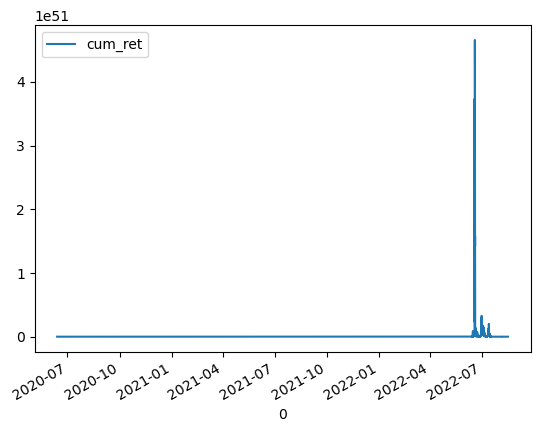

In [163]:
ax = df_pred_test.plot(x = 0, y = 'cum_ret')
plt.show()

In [101]:
params = {'num_columns': len(train_features_test),
          'num_labels': 3,
          'hidden_units': [96, 96, 896, 448, 448, 256],
          'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882,
                            0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448],
          'ls': 0,
          'lr': 1e-3,
          }

In [128]:
scores = []
batch_size = 4096
df_pred = []
for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, train_df['label'], groups)):
    min_train, max_train = min(train_df['open_time'].iloc[train_idx]).to_pydatetime(), max(
          train_df['open_time'].iloc[train_idx]).to_pydatetime()
    min_valid, max_valid = min(train_df['open_time'].iloc[val_idx]).to_pydatetime(), max(
          train_df['open_time'].iloc[val_idx]).to_pydatetime()

    x_train, x_val = train_df[train_features_test].iloc[train_idx], train_df[train_features_test].iloc[
        val_idx]
    y_train, y_val = train_df['label'].iloc[train_idx], train_df['label'].iloc[val_idx]


    print(f'{fold} : Train Date is from {min_train} - {max_train}')
    print(f'{fold} : Valid Date is from {min_valid} - {max_valid}')

    y_train, y_val = train_df['label'].iloc[train_idx].values, train_df['label'].iloc[val_idx].values

    if fold == 0:
        print(f'Shape of Xtrain is {x_train.shape}, Shape of yTrain is {y_train.shape}')

    if use_weights:
        weights = []
        for val in np.unique(y_train):
            prop = (y_train == val).sum() / y_train.shape[0]
            print(f'Class 0: train: {prop}')
            weights.append(prop)
        weights = np.array(weights)
        loss_weights = get_weights(weights)
        weights = {}
        for i in range(len(loss_weights)):
            weights[i] = loss_weights[i]

        y_train = tf.one_hot(y_train, depth = 3)
        y_val = tf.one_hot(y_val, depth = 3)

    model = create_ae_mlp(**params)
    model.load_weights(f'../output/AEMLP_{fold}_{batch_size}.hdf5')
    predictions = model.predict(x_val.values)
    ypred = pd.DataFrame(predictions[-1], columns = [f'prob_{i}' for i in range(3)])
    cols_to_keep = ['open_time', 'label', 'target_15m', 'token']
    tmp_df = pd.concat([train_df[cols_to_keep].iloc[val_idx].reset_index(drop = True), ypred], axis = 1, ignore_index = True)
    df_pred.append(tmp_df)


0 : Train Date is from 2020-01-01 00:00:00 - 2020-05-12 23:59:00
0 : Valid Date is from 2020-06-13 00:15:00 - 2020-11-18 23:59:00
Shape of Xtrain is (383040, 142), Shape of yTrain is (383040,)
Class 0: train: 0.5186664578111947
Class 0: train: 0.23460996240601503
Class 0: train: 0.2467235797827903
14310/14310 [==============================] - 31s 2ms/step
1 : Train Date is from 2020-01-01 00:00:00 - 2020-10-18 23:59:00
1 : Valid Date is from 2020-11-19 00:15:00 - 2021-04-26 23:59:00
Class 0: train: 0.6083868436073059
Class 0: train: 0.19091395547945206
Class 0: train: 0.200699200913242
14310/14310 [==============================] - 30s 2ms/step
2 : Train Date is from 2020-01-01 00:00:00 - 2021-03-26 23:59:00
2 : Valid Date is from 2021-04-27 00:15:00 - 2021-10-02 23:59:00
Class 0: train: 0.5450272542498152
Class 0: train: 0.22070861049519586
Class 0: train: 0.2342641352549889
14310/14310 [==============================] - 29s 2ms/step
3 : Train Date is from 2020-01-01 00:00:00 - 2021-

In [129]:
tmp_df

,0,1,2,3,4,5,6
0,2022-03-11 00:15:00,1,-0.005486,0,0.544133,0.220358,0.235509
1,2022-03-11 00:16:00,1,-0.002619,0,0.603810,0.193890,0.202299
2,2022-03-11 00:16:00,1,-0.003931,1,0.743910,0.134652,0.121438
3,2022-03-11 00:17:00,0,-0.001781,1,0.725732,0.145121,0.129147
4,2022-03-11 00:17:00,0,-0.001066,0,0.606421,0.192600,0.200979
...,...,...,...,...,...,...,...
455868,2022-08-16 07:09:00,0,0.000046,1,0.647001,0.169039,0.183960
455869,2022-08-16 07:10:00,0,-0.001018,1,0.575753,0.183874,0.240373
455870,2022-08-16 07:10:00,0,-0.000794,0,0.672766,0.145688,0.181546
455871,2022-08-16 07:11:00,0,-0.001515,0,0.609655,0.180602,0.209743


In [130]:
df_pred_test = pd.concat(df_pred, axis = 0)

In [134]:
df_pred_test.columns

Index([0, 1, 2, 3, 4, 5, 6, 'pred_label'], dtype='object')

In [135]:
df_pred_test = pd.concat(df_pred, axis = 0)
df_pred_test['pred_label'] = np.argmax(df_pred_test[[4, 5, 6]].values, axis = 1)

In [140]:
df_1 = df_pred_test.loc[(df_pred_test[1] == 1)]
acc_1 = (df_1[1] == df_1['pred_label']).sum() / df_1.shape[0]
df_2 = df_pred_test.loc[(df_pred_test[1] == 2)]
acc_2 = (df_2[1] == df_2['pred_label']).sum() / df_2.shape[0]

In [141]:
acc_2

0.11106521821471022